In [5]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# 1️⃣ Load dataset
df_train = pd.read_csv("data/features/session_based_trainset.csv")
print("Training dataset shape:", df_train.shape)
df_test = pd.read_csv("data/features/session_based_testset.csv")
print("Testing dataset shape:", df_test.shape)

Training dataset shape: (488524, 280)
Testing dataset shape: (122132, 280)


In [3]:
# 2️⃣ Use the correct label column
label_col = "label"
print("Unique values in label:", df_train[label_col].unique())
print("Unique values in label:", df_test[label_col].unique()) #is this flip-flop the source of a problem? Don't think so

Unique values in label: [0 1]
Unique values in label: [1 0]


In [4]:
# 3️⃣ Prepare features and target
y_raw = df_train[label_col]
X = df_train.drop(columns=[label_col]).fillna(0)

ytest_raw = df_test[label_col]
X_test = df_test.drop(columns=[label_col]).fillna(0) #new x test

In [5]:
# 4️⃣ Convert label text/numbers → binary
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1

y = y_raw.apply(map_label)
y_test = ytest_raw.apply(map_label) #new y test
print("\nBinary label distribution in train set (0=Benign, 1=Malicious):\n", y.value_counts())
print("\nBinary label distribution in test set (0=Benign, 1=Malicious):\n", y_test.value_counts())


Binary label distribution in train set (0=Benign, 1=Malicious):
 label
1    245470
0    243054
Name: count, dtype: int64

Binary label distribution in test set (0=Benign, 1=Malicious):
 label
0    61273
1    60859
Name: count, dtype: int64


In [6]:
# 5️⃣ Train/test split
'''X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nX Train:", X_train.shape, "X Test:", X_test.shape)'''

#no need to perform splits since there is an entire separate testing data set
X_train = X
y_train = y

In [9]:
# 6️⃣ Train Random Forest
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [10]:
# 7️⃣ Evaluate model
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
#the confusion matrix just below is showing correctly, but in the visualization it isn't showing bottom row correctly


Confusion Matrix:
[[61249    24]
 [   35 60824]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9996    0.9995     61273
           1     0.9996    0.9994    0.9995     60859

    accuracy                         0.9995    122132
   macro avg     0.9995    0.9995    0.9995    122132
weighted avg     0.9995    0.9995    0.9995    122132

ROC AUC: 1.0


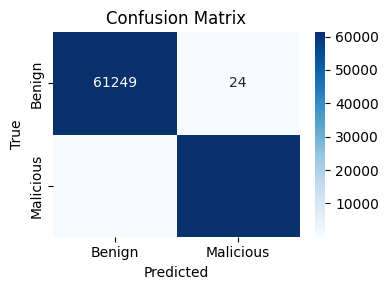

In [11]:
# 8️⃣ Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


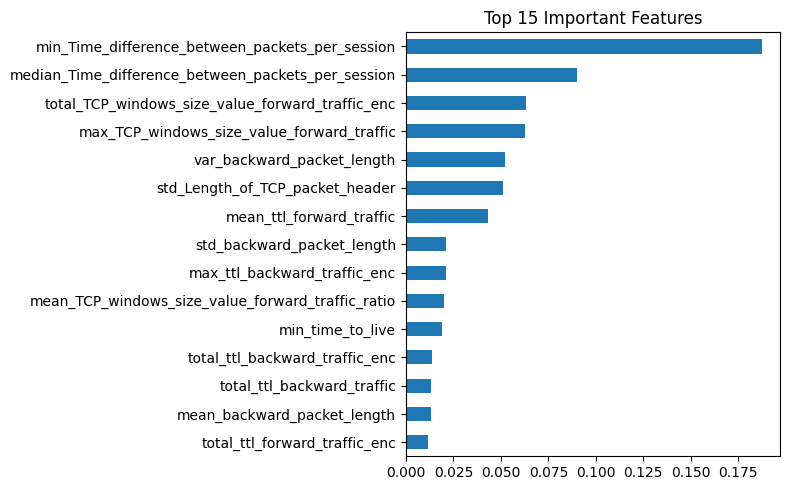

In [12]:
# 9️⃣ Feature Importance
imp = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
imp.head(15).plot(kind="barh", title="Top 15 Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [13]:
# 🔟 Save 
joblib.dump(xgb_model, "report/xgb_session_model.joblib")
imp.to_csv("report/xgb_feature_importance.csv", index=True)
print("\nModel and feature importances saved in report/")


Model and feature importances saved in report/


In [2]:
# 11 CICIDS2017 data set testing setup
df2 = pd.read_csv("data/CICIDS2017/cicids2017_combined_relabled2.csv")
df2 = df2.iloc[:, 2:] #ignore dummy rows
label_col = " Label"
print("Unique values in label:", df2[label_col].unique())
y_raw2 = df2[label_col]
X2 = df2.drop(columns=[label_col]).fillna(0)
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1
y2 = y_raw2.apply(map_label)
print("\nBinary label distribution (0=Benign, 1=Malicious):\n", y2.value_counts())

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.3, stratify=y2, random_state=42
)
#X_train = X
#y_train = y
print("\nTrain:", X_train2.shape, "Test:", X_test2.shape)

Unique values in label: ['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']

Binary label distribution (0=Benign, 1=Malicious):
  Label
0    2273097
1     557646
Name: count, dtype: int64

Train: (1981520, 78) Test: (849223, 78)


In [3]:
# 12 CICIDS2017 set testing training
xgb2 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgb2.fit(X_train2, y_train2)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'



Confusion Matrix:
[[681501    428]
 [   207 167087]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9994    0.9995    681929
           1     0.9974    0.9988    0.9981    167294

    accuracy                         0.9993    849223
   macro avg     0.9986    0.9991    0.9988    849223
weighted avg     0.9993    0.9993    0.9993    849223

ROC AUC: 1.0


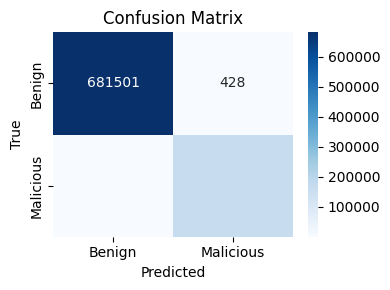

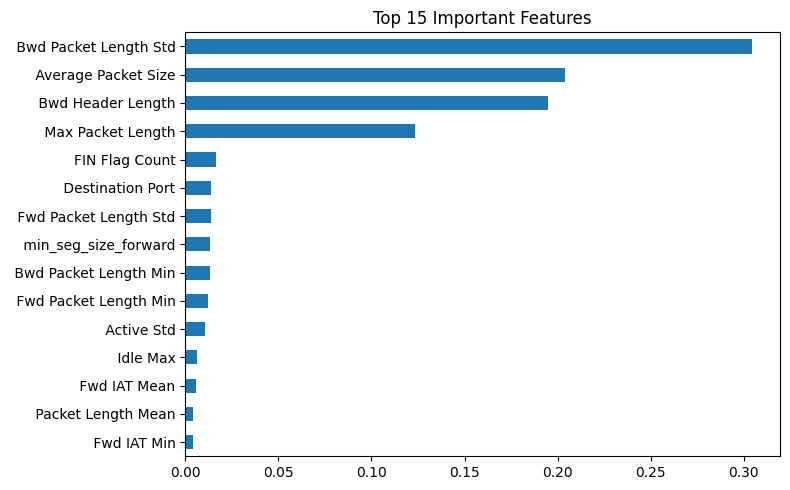

In [4]:
# 13 CICIDS2017 set testing evaluation
y_pred2 = xgb2.predict(X_test2)
y_proba2 = xgb2.predict_proba(X_test2)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test2, y_pred2))
print("\nClassification Report:")
print(classification_report(y_test2, y_pred2, digits=4))
print("ROC AUC:", round(roc_auc_score(y_test2, y_proba2), 4))

cm = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

imp = pd.Series(xgb2.feature_importances_, index=X2.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
imp.head(15).plot(kind="barh", title="Top 15 Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [6]:
# 14 CTU13 data set testing setup
df3 = pd.read_csv("data/ctu13/CTU13_Combined_Traffic.csv")
label_col = "Label"
print("Unique values in label:", df3[label_col].unique())
y_raw3 = df3[label_col]
X3 = df3.drop(columns=[label_col]).fillna(0)
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1
y3 = y_raw3.apply(map_label)
print("\nBinary label distribution (0=Benign, 1=Malicious):\n", y3.value_counts())

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X3, y3, test_size=0.3, stratify=y3, random_state=42
)
print("\nTrain:", X_train3.shape, "Test:", X_test3.shape)

Unique values in label: [1 0]

Binary label distribution (0=Benign, 1=Malicious):
 Label
0    53314
1    38898
Name: count, dtype: int64

Train: (64548, 57) Test: (27664, 57)


In [7]:
# 15 CTU13 set testing training
xgb3 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgb3.fit(X_train3, y_train3)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'



Confusion Matrix:
[[15981    13]
 [   36 11634]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9978    0.9992    0.9985     15994
           1     0.9989    0.9969    0.9979     11670

    accuracy                         0.9982     27664
   macro avg     0.9983    0.9981    0.9982     27664
weighted avg     0.9982    0.9982    0.9982     27664

ROC AUC: 0.9999


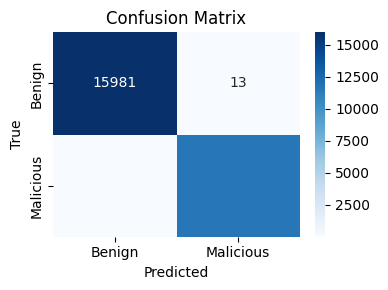

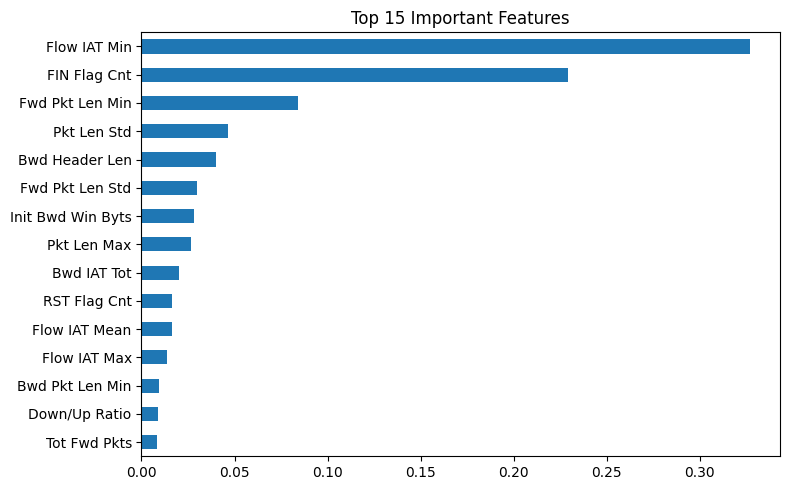

In [8]:
# 16 CTU13 set testing evaluation
y_pred3 = xgb3.predict(X_test3)
y_proba3 = xgb3.predict_proba(X_test3)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test3, y_pred3))
print("\nClassification Report:")
print(classification_report(y_test3, y_pred3, digits=4))
print("ROC AUC:", round(roc_auc_score(y_test3, y_proba3), 4))

cm = confusion_matrix(y_test3, y_pred3)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

imp = pd.Series(xgb3.feature_importances_, index=X3.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
imp.head(15).plot(kind="barh", title="Top 15 Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()